# Model 5: XGBoost with All Features

This notebook trains an **XGBoost** classifier on all available features (regular + all embeddings) with comprehensive preprocessing:
- ✅ All regular features
- ✅ All embedding families (PCA-compressed)
- ✅ Feature scaling (StandardScaler)
- ✅ 5-fold Cross-Validation
- ✅ Comprehensive Hyperparameter Tuning (RandomizedSearchCV)
- ✅ Threshold Fine-tuning
- ✅ Model Saving
- ✅ Submission.csv Generation
- ✅ OOM Safe with aggressive memory management
- ✅ Incremental SMOTE (ENN/Tomek) for class imbalance - OOM-resistant

# 📑 Model 5 - Code Navigation Index

## Quick Navigation
- **[Setup](#1-setup)** - Imports, paths, device configuration, robustness utilities
- **[Data Loading](#2-data-loading--feature-extraction)** - Load and split features
- **[PCA Preprocessing](#3-feature-preprocessing-pca)** - Embedding compression (if applicable)
- **[SMOTETomek](#4-class-imbalance-handling-smotetomek)** - Class imbalance resampling
- **[Feature Scaling](#5-feature-scaling)** - StandardScaler normalization
- **[Cross-Validation](#6-cross-validation--hyperparameter-tuning)** - Hyperparameter optimization
- **[Threshold Tuning](#7-threshold-tuning--final-evaluation)** - Optimal threshold finding
- **[Model Saving](#8-save-model)** - Save model weights and metadata
- **[Submission](#9-generate-submission)** - Generate test predictions

## Model Type: XGBoost (all features)

## Key Features
✅ GPU-friendly with CPU fallback  
✅ Aggressive garbage collection  
✅ OOM resistant with chunked processing  
✅ Kernel panic resistant (signal handlers, checkpoints)  
✅ Polars-only (no pandas)  
✅ GPU-friendly PCA (IncrementalTorchPCA option)  
✅ Incremental SMOTE (ENN/Tomek) for class imbalance - OOM-resistant  
✅ Feature scaling & embedding normalization  
✅ Hyperparameter tuning (RandomizedSearchCV/GridSearchCV)  
✅ Fine-grained threshold optimization (120+ thresholds)  
✅ Model weights saved  
✅ Chunked/batched data processing  

## Memory Management
- `cleanup_memory()`: Aggressive GC + GPU cache clearing
- `check_memory_safe()`: Pre-operation memory checks
- `chunked_operation()`: Process large data in chunks
- `safe_operation()`: Retry decorator with OOM handling
- Signal handlers: SIGINT/SIGTERM for graceful shutdown
- Checkpoints: Resume from failures

## Device Handling
- Automatic GPU detection with CPU fallback
- `device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')`
- All tensors moved to device explicitly
- GPU cache cleared aggressively after operations


## 1. Setup

In [1]:
import os
from pathlib import Path
import random
import gc
import numpy as np
import polars as pl
import torch
from typing import Dict, Optional
import sys
import time
import json
import pickle
import signal
import atexit
from functools import wraps
from datetime import datetime


In [2]:
# =========================
# STARTUP & REPRODUCIBILITY
# =========================

TOTAL_START_TIME = time.time()
START_TIME_STR = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print(f"\n{'='*80}")
print("MODEL_XGBOOST EXECUTION STARTED")
print(f"Start Time: {START_TIME_STR}")
print(f"{'='*80}\n")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



MODEL_XGBOOST EXECUTION STARTED
Start Time: 2025-11-20 00:40:53



Using device: cuda


In [3]:
# ==============
# PATH MANAGEMENT
# ==============

current = Path(os.getcwd())
PROJECT_ROOT = current
for _ in range(5):
    if (PROJECT_ROOT / "data").exists():
        break
    PROJECT_ROOT = PROJECT_ROOT.parent
else:
    PROJECT_ROOT = current.parent.parent

MODEL_READY_DIR = PROJECT_ROOT / "data" / "model_ready"
MODEL_SAVE_DIR = PROJECT_ROOT / "models" / "saved_models"
SUBMISSION_DIR = PROJECT_ROOT / "data" / "submission_files"
MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)
SUBMISSION_DIR.mkdir(parents=True, exist_ok=True)
utils_path = PROJECT_ROOT / "src" / "utils"
print("PROJECT_ROOT:", PROJECT_ROOT)
print("MODEL_READY_DIR:", MODEL_READY_DIR)

PROJECT_ROOT: /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2
MODEL_READY_DIR: /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/data/model_ready


In [4]:
# =======================
# PCA UTILITY IMPORTS
# =======================
USE_TORCH_PCA = False
if utils_path.exists():
    sys.path.insert(0, str(utils_path))

if USE_TORCH_PCA:
    try:
        from pca_utils import IncrementalTorchPCA
        IncrementalPCA = IncrementalTorchPCA
        IS_TORCH_PCA = True
        print("✅ Using PyTorch PCA (GPU-friendly)")
    except ImportError:
        from sklearn.decomposition import IncrementalPCA
        IS_TORCH_PCA = False
        print("⚠️ Using sklearn IncrementalPCA (CPU only)")
else:
    from sklearn.decomposition import IncrementalPCA
    IS_TORCH_PCA = False
    print("✅ Using sklearn IncrementalPCA (memory-efficient)")

✅ Using sklearn IncrementalPCA (memory-efficient)


In [5]:
# ==========
# ML LIBRARIES
# ==========
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, roc_auc_score, classification_report, precision_recall_curve, roc_curve, confusion_matrix
import xgboost as xgb
from xgboost import XGBClassifier

# ==========
# VISUALIZATION LIBRARIES
# ==========
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [6]:
# ===============================
# MEMORY UTILITIES (FALLBACK DEFS)
# ===============================
try:
    from model_training_utils import cleanup_memory, memory_usage, check_memory_safe
    print("✅ Memory utilities imported from shared module")
except ImportError:
    def cleanup_memory():
        """Aggressive memory cleanup for both CPU and GPU."""
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
            torch.cuda.ipc_collect()
        gc.collect()
    
    def memory_usage():
        """Display current memory usage statistics."""
        try:
            import psutil
            process = psutil.Process(os.getpid())
            mem_gb = process.memory_info().rss / 1024**3
            print(f"💾 Memory: {mem_gb:.2f} GB (RAM)", end="")
            if torch.cuda.is_available():
                gpu_mem = torch.cuda.memory_allocated() / 1024**3
                gpu_reserved = torch.cuda.memory_reserved() / 1024**3
                print(f" | {gpu_mem:.2f}/{gpu_reserved:.2f} GB (GPU used/reserved)")
            else:
                print()
        except:
            pass
    
    def check_memory_safe(ram_threshold_gb=0.85, gpu_threshold=0.80):
        """Check if memory usage is safe for operations."""
        try:
            import psutil
            process = psutil.Process(os.getpid())
            ram_gb = process.memory_info().rss / 1024**3
            total_ram = psutil.virtual_memory().total / 1024**3
            ram_ratio = ram_gb / total_ram if total_ram > 0 else 0
            gpu_ratio = 0
            if torch.cuda.is_available():
                gpu_used = torch.cuda.memory_allocated() / 1024**3
                gpu_total = torch.cuda.get_device_properties(0).total_memory / 1024**3
                gpu_ratio = gpu_used / gpu_total if gpu_total > 0 else 0
            is_safe = ram_ratio < ram_threshold_gb and gpu_ratio < gpu_threshold
            return is_safe, {"ram_gb": ram_gb, "ram_ratio": ram_ratio, "gpu_ratio": gpu_ratio}
        except:
            return True, {}
    
    print("⚠️ Using fallback memory utilities")

memory_usage()

✅ Memory utilities imported from shared module
💾 Memory: 0.62 GB (RAM) | 0.00/0.00 GB (GPU used/reserved)


In [7]:
# ===============================
# ROBUSTNESS/CHECKPOINT UTILITIES
# ===============================

_checkpoint_state = {
    "pca_complete": False,
    "scaling_complete": False,
    "cv_complete": False,
    "final_model_trained": False,
    "last_saved_checkpoint": None,
}

def save_checkpoint(state_name: str, data: dict, checkpoint_dir: Path = None):
    """Save checkpoint to resume from failures."""
    if checkpoint_dir is None:
        checkpoint_dir = PROJECT_ROOT / "data" / "checkpoints"
    checkpoint_dir.mkdir(parents=True, exist_ok=True)
    checkpoint_path = checkpoint_dir / f"model_xgboost_checkpoint_{state_name}.pkl"
    try:
        with open(checkpoint_path, "wb") as f:
            pickle.dump(data, f)
        _checkpoint_state["last_saved_checkpoint"] = checkpoint_path
        print(f"✅ Checkpoint saved: {checkpoint_path}")
    except Exception as e:
        print(f"⚠️ Failed to save checkpoint: {e}")

def load_checkpoint(state_name: str, checkpoint_dir: Path = None):
    """Load checkpoint to resume from failures."""
    if checkpoint_dir is None:
        checkpoint_dir = PROJECT_ROOT / "data" / "checkpoints"
    checkpoint_path = checkpoint_dir / f"model_xgboost_checkpoint_{state_name}.pkl"
    if checkpoint_path.exists():
        try:
            with open(checkpoint_path, "rb") as f:
                data = pickle.load(f)
            print(f"✅ Checkpoint loaded: {checkpoint_path}")
            return data
        except Exception as e:
            print(f"⚠️ Failed to load checkpoint: {e}")
    return None

def safe_operation(operation_name: str, max_retries: int = 3, checkpoint_on_success: bool = False):
    """Decorator for safe operations with retry and checkpoint support."""
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            for attempt in range(max_retries):
                try:
                    is_safe, mem_info = check_memory_safe(ram_threshold_gb=0.80, gpu_threshold=0.75)
                    if not is_safe:
                        cleanup_memory()
                        if torch.cuda.is_available():
                            torch.cuda.empty_cache()
                        time.sleep(1)
                    result = func(*args, **kwargs)
                    cleanup_memory()
                    if checkpoint_on_success:
                        save_checkpoint(operation_name, {"status": "complete", "result": result})
                    return result
                except (MemoryError, RuntimeError) as e:
                    error_msg = str(e).lower()
                    if "out of memory" in error_msg or "oom" in error_msg:
                        if attempt < max_retries - 1:
                            cleanup_memory()
                            if torch.cuda.is_available():
                                torch.cuda.empty_cache()
                            time.sleep(2)
                            continue
                        else:
                            raise
                    else:
                        raise
                except Exception as e:
                    if attempt < max_retries - 1:
                        cleanup_memory()
                        time.sleep(1)
                        continue
                    else:
                        raise
            return None
        return wrapper
    return decorator

def chunked_operation(
    data,
    operation_func,
    chunk_size: int = 10000,
    progress_every: int = 10,
    operation_name: str = "operation",
):
    """Execute operation on data in chunks with progress tracking."""
    total_chunks = (len(data) + chunk_size - 1) // chunk_size
    results = []
    for i in range(0, len(data), chunk_size):
        chunk_num = i // chunk_size + 1
        chunk = data[i : i + chunk_size]
        try:
            is_safe, mem_info = check_memory_safe(ram_threshold_gb=0.85, gpu_threshold=0.80)
            if not is_safe:
                cleanup_memory()
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                time.sleep(0.5)
            chunk_result = operation_func(chunk)
            results.append(chunk_result)
            if chunk_num % progress_every == 0 or chunk_num == total_chunks:
                print(f"  Progress: {chunk_num}/{total_chunks} chunks ({chunk_num*100//total_chunks}%)")
            del chunk
            if chunk_num % 5 == 0:
                cleanup_memory()
        except (MemoryError, RuntimeError) as e:
            error_msg = str(e).lower()
            if "out of memory" in error_msg or "oom" in error_msg:
                cleanup_memory()
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                smaller_chunk_size = max(1000, chunk_size // 2)
                if smaller_chunk_size < chunk_size:
                    return chunked_operation(
                        data[i:],
                        operation_func,
                        chunk_size=smaller_chunk_size,
                        progress_every=progress_every,
                        operation_name=operation_name,
                    )
                else:
                    raise
            else:
                raise
    return results

def emergency_cleanup():
    """Emergency cleanup on exit."""
    try:
        cleanup_memory()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        print("✅ Emergency cleanup completed")
    except:
        pass

atexit.register(emergency_cleanup)

def signal_handler(signum, frame):
    """Handle signals for graceful shutdown."""
    print(f"⚠️ Received signal {signum}, saving checkpoint...")
    save_checkpoint("emergency", {"status": "signal_received", "signal": signum})
    emergency_cleanup()
    raise KeyboardInterrupt

try:
    signal.signal(signal.SIGINT, signal_handler)
    signal.signal(signal.SIGTERM, signal_handler)
except:
    pass
print("✅ Enhanced robustness utilities loaded")

def safe_prediction(predict_func, *args, **kwargs):
    """Execute prediction with chunked processing."""
    try:
        is_safe, mem_info = check_memory_safe(ram_threshold_gb=0.85, gpu_threshold=0.80)
        if not is_safe:
            cleanup_memory()
        if "X" in kwargs and len(kwargs["X"]) > 50000:
            X = kwargs["X"]
            chunk_size = 10000
            predictions = []
            for i in range(0, len(X), chunk_size):
                chunk = X[i : i + chunk_size]
                kwargs["X"] = chunk
                chunk_preds = predict_func(*args, **kwargs)
                predictions.append(chunk_preds)
                del chunk, chunk_preds
                if i % (chunk_size * 5) == 0:
                    cleanup_memory()
            return np.concatenate(predictions)
        else:
            return predict_func(*args, **kwargs)
    except (MemoryError, RuntimeError) as e:
        error_msg = str(e).lower()
        if "out of memory" in error_msg or "oom" in error_msg:
            cleanup_memory()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            if "X" in kwargs:
                X = kwargs["X"]
                chunk_size = 5000
                predictions = []
                for i in range(0, len(X), chunk_size):
                    chunk = X[i : i + chunk_size]
                    kwargs["X"] = chunk
                    chunk_preds = predict_func(*args, **kwargs)
                    predictions.append(chunk_preds)
                    del chunk, chunk_preds
                    cleanup_memory()
                return np.concatenate(predictions)
            else:
                raise
        else:
            raise

print("✅ Training robustness wrappers loaded")


✅ Enhanced robustness utilities loaded
✅ Training robustness wrappers loaded


## 2. Data Loading & Feature Extraction

In [8]:
def load_parquet_split(split: str) -> pl.DataFrame:
    """Load a model_ready parquet split with error handling."""
    try:
        path = MODEL_READY_DIR / f"{split}_model_ready.parquet"
        if not path.exists():
            alt = MODEL_READY_DIR / f"{split}_model_ready_reduced.parquet"
            if alt.exists():
                path = alt
            else:
                raise FileNotFoundError(f"Could not find {split} data")
        print(f"Loading {split} from {path}")
        return pl.read_parquet(path)
    except Exception as e:
        print(f"❌ Error loading {split}: {e}")
        raise


def split_features_reg_and_all_emb(df: pl.DataFrame):
    """Split features into regular and embedding families."""
    cols = df.columns
    dtypes = df.dtypes
    label = df["label"].to_numpy() if "label" in cols else None

    reg_cols = []
    EMBEDDING_FAMILY_PREFIXES = ["sent_transformer_", "scibert_", "specter_", "specter2_", "ner_"]
    emb_family_to_cols = {p: [] for p in EMBEDDING_FAMILY_PREFIXES}

    NUMERIC_DTYPES = {
        pl.Int8,
        pl.Int16,
        pl.Int32,
        pl.Int64,
        pl.UInt8,
        pl.UInt16,
        pl.UInt32,
        pl.UInt64,
        pl.Float32,
        pl.Float64,
    }

    for c, dt in zip(cols, dtypes):
        if c in ("id", "label"):
            continue
        matched = False
        for p in EMBEDDING_FAMILY_PREFIXES:
            if c.startswith(p):
                emb_family_to_cols[p].append(c)
                matched = True
                break
        if not matched and dt in NUMERIC_DTYPES:
            reg_cols.append(c)

    X_reg = df.select(reg_cols).to_numpy() if reg_cols else None
    X_emb_families = {}
    for p, clist in emb_family_to_cols.items():
        if clist:
            X_emb_families[p] = df.select(clist).to_numpy()

    return X_reg, X_emb_families, label, reg_cols, emb_family_to_cols


# Load data
try:
    print("\n" + "=" * 80)
    print("PHASE 1: Data Loading")
    print("=" * 80)
    phase_start = time.time()
    
    train_df = load_parquet_split("train")
    val_df = load_parquet_split("val")

    X_reg_train, X_emb_train_fams, y_train, reg_cols, emb_family_to_cols = (
        split_features_reg_and_all_emb(train_df)
    )
    X_reg_val, X_emb_val_fams, y_val, _, _ = split_features_reg_and_all_emb(val_df)

    phase_time = time.time() - phase_start
    print(f"\n📊 Data Summary:")
    print(f"  Regular features: {len(reg_cols)}")
    for fam, arr in X_emb_train_fams.items():
        print(f"  Embedding {fam}: {arr.shape[1]} dims")
    print(
        f"  Train samples: {len(y_train)}, Positive: {y_train.sum()}, Negative: {(y_train==0).sum()}"
    )
    print(f"  Val samples: {len(y_val)}, Positive: {y_val.sum()}, Negative: {(y_val==0).sum()}")
    print(f"\n⏱️  Data Loading Time: {phase_time:.2f} seconds ({phase_time/60:.2f} minutes)")

    del train_df, val_df
    cleanup_memory()
    memory_usage()
except Exception as e:
    print(f"❌ Error loading data: {e}")
    raise


PHASE 1: Data Loading
Loading train from /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/data/model_ready/train_model_ready.parquet


Loading val from /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/data/model_ready/val_model_ready.parquet



📊 Data Summary:
  Regular features: 54
  Embedding sent_transformer_: 384 dims
  Embedding scibert_: 768 dims
  Embedding specter2_: 768 dims
  Train samples: 960000, Positive: 65808, Negative: 894192
  Val samples: 120000, Positive: 8075, Negative: 111925

⏱️  Data Loading Time: 168.12 seconds (2.80 minutes)


💾 Memory: 32.75 GB (RAM) | 0.00/0.00 GB (GPU used/reserved)


## 3. Feature Preprocessing: PCA

In [9]:
# PCA OPTION: Set to False to use all embeddings without PCA compression
USE_PCA = False  # Set to False to skip PCA and use all features (like PyTorch MLP)

# PCA compression per embedding family (only used if USE_PCA=True)
PCA_COMPONENTS_PER_FAMILY = {
    "sent_transformer_": 32,
    "scibert_": 32,
    "specter_": 32,
    "specter2_": 32,
    "ner_": 16,
}

In [10]:
@safe_operation("pca", max_retries=3, checkpoint_on_success=True)
def apply_pca_to_embeddings(
    X_emb_fams: Dict[str, np.ndarray], fit_on_train: bool = True, pca_models: Optional[Dict] = None
):
    """Apply IncrementalPCA to each embedding family (GPU-friendly, OOM-resistant)."""
    X_emb_pca_list = []
    new_pca_models = {}

    cleanup_memory()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

    # Memory safety check before PCA
    is_safe, mem_info = check_memory_safe(ram_threshold_gb=0.75, gpu_threshold=0.70)
    if not is_safe:
        print(f"⚠️ Memory usage high before PCA: {mem_info}")
        cleanup_memory()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    for fam, X_emb in X_emb_fams.items():
        n_components = PCA_COMPONENTS_PER_FAMILY.get(fam, 32)
        try:
            cleanup_memory()

            # Fit PCA model if training or no model given
            if fit_on_train or pca_models is None:
                ipca_args = {
                    "n_components": min(n_components, X_emb.shape[1]),
                    "batch_size": 2000
                }
                if IS_TORCH_PCA:
                    ipca_args["device"] = device
                ipca = IncrementalPCA(**ipca_args)

                # Fit PCA on subset for big data
                max_pca_rows = int(X_emb.shape[0] * 0.3)
                if X_emb.shape[0] > max_pca_rows:
                    print(f"  Fitting PCA on subset ({max_pca_rows}/{X_emb.shape[0]} samples) for {fam}")
                    idx = np.random.choice(X_emb.shape[0], size=max_pca_rows, replace=False)
                    X_emb_subset = X_emb[idx].copy()
                    del idx
                    cleanup_memory()
                    ipca.fit(X_emb_subset)
                    del X_emb_subset
                    cleanup_memory()
                else:
                    X_emb_copy = X_emb.copy() if not X_emb.flags["OWNDATA"] else X_emb
                    ipca.fit(X_emb_copy)
                    if X_emb_copy is not X_emb:
                        del X_emb_copy
                    cleanup_memory()

                new_pca_models[fam] = ipca
            else:
                ipca = pca_models[fam]

            # Transform in chunks for memory efficiency
            chunk_size = 2000
            if X_emb.shape[0] > chunk_size:
                X_emb_pca_chunks = []
                for i in range(0, X_emb.shape[0], chunk_size):
                    chunk = X_emb[i : i + chunk_size].copy()
                    chunk_pca = ipca.transform(chunk)
                    X_emb_pca_chunks.append(chunk_pca)
                    del chunk, chunk_pca
                    cleanup_memory()
                    if i % (chunk_size * 5) == 0 and torch.cuda.is_available():
                        torch.cuda.empty_cache()
                X_emb_pca = np.vstack(X_emb_pca_chunks)
                del X_emb_pca_chunks
                cleanup_memory()
            else:
                X_emb_copy = X_emb.copy() if not X_emb.flags["OWNDATA"] else X_emb
                X_emb_pca = ipca.transform(X_emb_copy)
                if X_emb_copy is not X_emb:
                    del X_emb_copy
                cleanup_memory()

            X_emb_pca_list.append(X_emb_pca)
            del X_emb_pca
            cleanup_memory()

            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                torch.cuda.synchronize()

        except RuntimeError as e:
            if "out of memory" in str(e).lower() or "OOM" in str(e).upper():
                print(f"❌ OOM error processing {fam}")
                cleanup_memory()
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                    torch.cuda.synchronize()
                raise
            else:
                raise

    cleanup_memory()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    X_emb_combined = np.hstack(X_emb_pca_list) if X_emb_pca_list else None
    return X_emb_combined, new_pca_models if fit_on_train else pca_models

# Apply PCA to embeddings (if enabled) or use embeddings directly
try:
    print("\n" + "=" * 80)
    if USE_PCA:
        print("PHASE 2: PCA Preprocessing")
    else:
        print("PHASE 2: Feature Preprocessing (No PCA)")
    print("=" * 80)
    phase_start = time.time()
    
    cleanup_memory()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

    if USE_PCA:
        print("\n📊 Applying IncrementalPCA to embedding families...")
        for fam in X_emb_train_fams.keys():
            n_comp = PCA_COMPONENTS_PER_FAMILY.get(fam, 32)
            print(f"  {fam}: {X_emb_train_fams[fam].shape[1]} dims → {n_comp} components")

        # Train PCA models on train
        X_emb_train_pca, pca_models_train = apply_pca_to_embeddings(
            X_emb_train_fams, fit_on_train=True
        )

        cleanup_memory()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # Transform validation using trained PCA models
        X_emb_val_pca, _ = apply_pca_to_embeddings(
            X_emb_val_fams, fit_on_train=False, pca_models=pca_models_train
        )

        phase_time = time.time() - phase_start
        print(f"\n📊 After IncrementalPCA:")
        print(f"  Train embeddings: {X_emb_train_pca.shape}")
        print(f"  Val embeddings: {X_emb_val_pca.shape}")

        # Combine regular + embedding features
        if X_reg_train is not None:
            X_train = np.hstack([X_reg_train, X_emb_train_pca])
            X_val = np.hstack([X_reg_val, X_emb_val_pca])
        else:
            X_train = X_emb_train_pca
            X_val = X_emb_val_pca
        
        # Store PCA models for later (model saving)
        pca_models = pca_models_train
        
        print(f"  Combined train: {X_train.shape}")
        print(f"  Combined val: {X_val.shape}")
        print(f"\n⏱️  PCA Preprocessing Time: {phase_time:.2f} seconds ({phase_time/60:.2f} minutes)")

        del X_reg_train, X_reg_val, X_emb_train_fams, X_emb_val_fams, X_emb_train_pca, X_emb_val_pca
    else:
        print("\n📊 Using all embeddings without PCA compression...")
        for fam in X_emb_train_fams.keys():
            print(f"  {fam}: {X_emb_train_fams[fam].shape[1]} dims (no compression)")

        # Combine all embeddings directly (no PCA)
        X_emb_train_list = [X_emb_train_fams[fam] for fam in X_emb_train_fams.keys()]
        X_emb_val_list = [X_emb_val_fams[fam] for fam in X_emb_val_fams.keys()]
        
        X_emb_train_combined = np.hstack(X_emb_train_list) if X_emb_train_list else None
        X_emb_val_combined = np.hstack(X_emb_val_list) if X_emb_val_list else None

        phase_time = time.time() - phase_start
        print(f"\n📊 After combining embeddings:")
        print(f"  Train embeddings: {X_emb_train_combined.shape}")
        print(f"  Val embeddings: {X_emb_val_combined.shape}")

        # Combine regular + embedding features
        if X_reg_train is not None:
            X_train = np.hstack([X_reg_train, X_emb_train_combined])
            X_val = np.hstack([X_reg_val, X_emb_val_combined])
        else:
            X_train = X_emb_train_combined
            X_val = X_emb_val_combined
        
        # No PCA models to store
        pca_models = {}
        
        print(f"  Combined train: {X_train.shape}")
        print(f"  Combined val: {X_val.shape}")
        print(f"\n⏱️  Feature Preprocessing Time: {phase_time:.2f} seconds ({phase_time/60:.2f} minutes)")

        del X_reg_train, X_reg_val, X_emb_train_fams, X_emb_val_fams, X_emb_train_list, X_emb_val_list, X_emb_train_combined, X_emb_val_combined
    
    cleanup_memory()
    memory_usage()
except Exception as e:
    print(f"❌ Error in preprocessing: {e}")
    raise


PHASE 2: Feature Preprocessing (No PCA)



📊 Using all embeddings without PCA compression...
  sent_transformer_: 384 dims (no compression)
  scibert_: 768 dims (no compression)
  specter2_: 768 dims (no compression)



📊 After combining embeddings:
  Train embeddings: (960000, 1920)
  Val embeddings: (120000, 1920)


  Combined train: (960000, 1974)
  Combined val: (120000, 1974)

⏱️  Feature Preprocessing Time: 14.78 seconds (0.25 minutes)


💾 Memory: 39.03 GB (RAM) | 0.00/0.00 GB (GPU used/reserved)


## 4. Class Imbalance Handling: SMOTETomek

In [11]:
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Incremental SMOTE configuration for OOM-resistant processing
# We always apply SMOTE - never skip it, even for large datasets
USE_INCREMENTAL_SMOTE = True  # Always use chunked processing for better memory management
SMOTE_CHUNK_SIZE = 10_000  # Process in chunks of 10k samples for optimal memory usage
SMOTE_SAMPLE_RATIO = 0.5  # Apply SMOTE to 50% of the data to balance effectiveness and memory

# SMOTE method selection: "enn" (default) or "tomek"
# ENN (Edited Nearest Neighbours) is more aggressive and better for noisy data
# Tomek links is less aggressive and preserves more original samples
SMOTE_METHOD = "enn"  # Default: ENN for better noise handling

method_name = "SMOTEENN" if SMOTE_METHOD == "enn" else "SMOTETomek"

print("\n" + "=" * 80)
print(f"PHASE 3: {method_name} Resampling (OOM-Resistant)")
print("=" * 80)
phase_start = time.time()

print("\n📊 Checking class imbalance and applying incremental SMOTE resampling...")
print(f"  Before: {len(X_train)} samples, Positive: {y_train.sum()}, Negative: {(y_train == 0).sum()}")
print(f"  Imbalance ratio: {(y_train == 0).sum() / max(y_train.sum(), 1):.2f}:1")

# Check memory before SMOTE and clean up if needed
is_safe, mem_info = check_memory_safe(ram_threshold_gb=0.65, gpu_threshold=0.65)
if not is_safe:
    print(f"  ⚠️  Memory usage high before SMOTE: {mem_info}")
    print("  Performing aggressive cleanup...")
    cleanup_memory()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# We always apply SMOTE - no skipping allowed
USE_CLASS_WEIGHT = False

# Sample a portion of data for SMOTE (stratified to preserve class distribution)
# This helps manage memory while still applying SMOTE to a representative sample
print(f"\n  Sampling {SMOTE_SAMPLE_RATIO*100:.0f}% of data for {method_name} resampling...")
X_train_smote, X_train_keep, y_train_smote, y_train_keep = train_test_split(
    X_train, y_train,
    test_size=1 - SMOTE_SAMPLE_RATIO,
    stratify=y_train,
    random_state=42
)
print(f"  SMOTE sample: {len(X_train_smote)} samples (pos: {y_train_smote.sum()}, neg: {(y_train_smote==0).sum()})")
print(f"  Keep as-is: {len(X_train_keep)} samples (pos: {y_train_keep.sum()}, neg: {(y_train_keep==0).sum()})")

# Cleanup original data to free memory
del X_train, y_train
cleanup_memory()

# Always use incremental SMOTE for better memory management
if USE_INCREMENTAL_SMOTE and len(X_train_smote) > SMOTE_CHUNK_SIZE:
    print(f"\n  Using incremental {method_name} with chunk size: {SMOTE_CHUNK_SIZE:,} samples")
    
    # Determine sampling strategy based on dataset size
    # Smaller strategy values mean less aggressive resampling, which uses less memory
    if len(X_train_smote) > 100_000:
        sampling_strategy = 0.15  # Moderate resampling for very large datasets
    elif len(X_train_smote) > 50_000:
        sampling_strategy = 0.25  # Balanced resampling for large datasets
    else:
        sampling_strategy = 0.35  # More aggressive resampling for smaller datasets
    
    print(f"  Sampling strategy: {sampling_strategy} (target minority/majority ratio)")
    
    # Shuffle data to ensure good class mixing across chunks
    # This helps each chunk have a representative sample of both classes
    print(f"  Shuffling data to ensure good class distribution across chunks...")
    X_train_shuffled, y_train_shuffled = shuffle(X_train_smote, y_train_smote, random_state=42)
    del X_train_smote, y_train_smote
    cleanup_memory()
    
    n_chunks = (len(X_train_shuffled) + SMOTE_CHUNK_SIZE - 1) // SMOTE_CHUNK_SIZE
    print(f"  Processing {n_chunks} chunks of up to {SMOTE_CHUNK_SIZE:,} samples each...")
    
    X_resampled_chunks = []
    y_resampled_chunks = []
    
    # Process each chunk sequentially with robust error handling
    for chunk_idx in range(n_chunks):
        start_idx = chunk_idx * SMOTE_CHUNK_SIZE
        end_idx = min(start_idx + SMOTE_CHUNK_SIZE, len(X_train_shuffled))
        
        X_chunk = X_train_shuffled[start_idx:end_idx].copy()
        y_chunk = y_train_shuffled[start_idx:end_idx].copy()
        
        # Only apply SMOTE if chunk has both classes (required for resampling)
        if y_chunk.sum() > 0 and (y_chunk == 0).sum() > 0:
            print(f"    Chunk {chunk_idx + 1}/{n_chunks}: {len(X_chunk)} samples (pos: {y_chunk.sum()}, neg: {(y_chunk==0).sum()})")
            
            # Create SMOTE instance based on selected method
            # Using n_jobs=1 to avoid memory spikes from parallel processing
            if SMOTE_METHOD == "enn":
                smote = SMOTEENN(
                    random_state=42 + chunk_idx,  # Different seed per chunk for diversity
                    sampling_strategy=sampling_strategy,
                    n_jobs=1  # Single job to minimize memory usage
                )
            else:  # tovek
                smote = SMOTETomek(
                    random_state=42 + chunk_idx,
                    sampling_strategy=sampling_strategy,
                    n_jobs=1
                )
            
            # Apply SMOTE with retry logic for OOM resilience
            max_retries = 3
            retry_chunk_size = len(X_chunk)
            chunk_resampled = False
            
            for retry in range(max_retries):
                try:
                    # Check memory before SMOTE
                    is_safe, _ = check_memory_safe(ram_threshold_gb=0.75, gpu_threshold=0.75)
                    if not is_safe:
                        cleanup_memory()
                        if torch.cuda.is_available():
                            torch.cuda.empty_cache()
                        time.sleep(0.5)  # Brief pause to let memory settle
                    
                    # Apply SMOTE resampling
                    X_chunk_resampled, y_chunk_resampled = smote.fit_resample(X_chunk, y_chunk)
                    X_resampled_chunks.append(X_chunk_resampled)
                    y_resampled_chunks.append(y_chunk_resampled)
                    
                    print(f"      ✓ Resampled to {len(X_chunk_resampled)} samples")
                    chunk_resampled = True
                    
                    # Cleanup immediately after successful resampling
                    del smote, X_chunk_resampled, y_chunk_resampled
                    cleanup_memory()
                    break
                    
                except (MemoryError, RuntimeError) as e:
                    error_msg = str(e).lower()
                    if ("out of memory" in error_msg or "oom" in error_msg) and retry < max_retries - 1:
                        # If OOM, try with a smaller subset of the chunk
                        print(f"      ⚠️  Memory error on retry {retry + 1}, trying smaller subset...")
                        cleanup_memory()
                        if torch.cuda.is_available():
                            torch.cuda.empty_cache()
                        
                        # Use a smaller subset for next retry
                        subset_size = retry_chunk_size // 2
                        if subset_size < 1000:  # Minimum viable chunk size
                            print(f"      ⚠️  Chunk too small, using original chunk")
                            X_resampled_chunks.append(X_chunk)
                            y_resampled_chunks.append(y_chunk)
                            chunk_resampled = True
                            break
                        
                        # Try with smaller subset
                        idx_subset = np.random.choice(len(X_chunk), size=subset_size, replace=False)
                        X_chunk = X_chunk[idx_subset]
                        y_chunk = y_chunk[idx_subset]
                        retry_chunk_size = subset_size
                        time.sleep(1)  # Wait before retry
                    else:
                        # Final retry failed or non-OOM error - use original chunk
                        print(f"      ⚠️  SMOTE failed after {retry + 1} attempts, using original chunk")
                        X_resampled_chunks.append(X_chunk)
                        y_resampled_chunks.append(y_chunk)
                        chunk_resampled = True
                        break
                except Exception as e:
                    # Other errors - use original chunk and continue
                    print(f"      ⚠️  Unexpected error: {e}, using original chunk")
                    X_resampled_chunks.append(X_chunk)
                    y_resampled_chunks.append(y_chunk)
                    chunk_resampled = True
                    break
            
            # Ensure chunk was processed
            if not chunk_resampled:
                X_resampled_chunks.append(X_chunk)
                y_resampled_chunks.append(y_chunk)
            
            # Cleanup chunk data
            del X_chunk, y_chunk
            cleanup_memory()
            
        else:
            # Chunk has only one class - keep as is (SMOTE requires both classes)
            print(f"    Chunk {chunk_idx + 1}/{n_chunks}: {len(X_chunk)} samples (single class, keeping as-is)")
            X_resampled_chunks.append(X_chunk)
            y_resampled_chunks.append(y_chunk)
            del X_chunk, y_chunk
        
        # Periodic cleanup every few chunks to prevent memory accumulation
        if (chunk_idx + 1) % 3 == 0:
            cleanup_memory()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    # Combine all resampled chunks into final training set
    print(f"\n  Combining {len(X_resampled_chunks)} resampled chunks...")
    X_train_smote_resampled = np.vstack(X_resampled_chunks)
    y_train_smote_resampled = np.hstack(y_resampled_chunks)
    
    del X_resampled_chunks, y_resampled_chunks, X_train_shuffled, y_train_shuffled
    cleanup_memory()
    
    # Combine resampled SMOTE sample with the kept portion
    print(f"  Combining resampled data with kept portion...")
    X_train = np.vstack([X_train_smote_resampled, X_train_keep])
    y_train = np.hstack([y_train_smote_resampled, y_train_keep])
    
    del X_train_smote_resampled, y_train_smote_resampled, X_train_keep, y_train_keep
    cleanup_memory()
    
    phase_time = time.time() - phase_start
    print(f"\n  ✅ After resampling: {len(X_train)} samples")
    print(f"     Positive: {y_train.sum()}, Negative: {(y_train == 0).sum()}")
    print(f"     Balance ratio: {(y_train == 0).sum() / max(y_train.sum(), 1):.2f}:1")
    print(f"\n⏱️  Incremental {method_name} Time: {phase_time:.2f} seconds ({phase_time/60:.2f} minutes)")
    
else:
    # For smaller datasets that fit in memory, use standard SMOTE
    # Still chunked if needed, but can process larger chunks
    print(f"\n  Using standard {method_name} (dataset fits in memory)")
    
    # Determine parameters based on dataset size
    if len(X_train_smote) > 50_000:
        sampling_strategy = 0.25
        n_jobs_smote = 1  # Single job for memory safety
    else:
        sampling_strategy = 0.35
        n_jobs_smote = 1  # Still single job to be safe
    
    # Create SMOTE instance
    if SMOTE_METHOD == "enn":
        smote = SMOTEENN(random_state=42, sampling_strategy=sampling_strategy, n_jobs=n_jobs_smote)
    else:  # tovek
        smote = SMOTETomek(random_state=42, sampling_strategy=sampling_strategy, n_jobs=n_jobs_smote)
    
    print(f"  Fitting {method_name} on sample...")
    cleanup_memory()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Apply SMOTE with error handling - fallback to incremental if needed
    try:
        X_train_smote_resampled, y_train_smote_resampled = smote.fit_resample(X_train_smote, y_train_smote)
    except (MemoryError, RuntimeError) as e:
        error_msg = str(e).lower()
        if "out of memory" in error_msg or "oom" in error_msg:
            print(f"  ⚠️  Memory error, falling back to incremental processing...")
            # Fall back to incremental approach with smaller chunks
            X_train_shuffled, y_train_shuffled = shuffle(X_train_smote, y_train_smote, random_state=42)
            del X_train_smote, y_train_smote
            cleanup_memory()
            
            # Process in smaller chunks
            n_chunks = (len(X_train_shuffled) + SMOTE_CHUNK_SIZE - 1) // SMOTE_CHUNK_SIZE
            X_resampled_chunks = []
            y_resampled_chunks = []
            
            for chunk_idx in range(n_chunks):
                start_idx = chunk_idx * SMOTE_CHUNK_SIZE
                end_idx = min(start_idx + SMOTE_CHUNK_SIZE, len(X_train_shuffled))
                X_chunk = X_train_shuffled[start_idx:end_idx]
                y_chunk = y_train_shuffled[start_idx:end_idx]
                
                if y_chunk.sum() > 0 and (y_chunk == 0).sum() > 0:
                    if SMOTE_METHOD == "enn":
                        smote_chunk = SMOTEENN(random_state=42 + chunk_idx, sampling_strategy=sampling_strategy, n_jobs=1)
                    else:
                        smote_chunk = SMOTETomek(random_state=42 + chunk_idx, sampling_strategy=sampling_strategy, n_jobs=1)
                    
                    try:
                        X_chunk_resampled, y_chunk_resampled = smote_chunk.fit_resample(X_chunk, y_chunk)
                        X_resampled_chunks.append(X_chunk_resampled)
                        y_resampled_chunks.append(y_chunk_resampled)
                    except:
                        X_resampled_chunks.append(X_chunk)
                        y_resampled_chunks.append(y_chunk)
                    finally:
                        del X_chunk, y_chunk
                        cleanup_memory()
                else:
                    X_resampled_chunks.append(X_chunk)
                    y_resampled_chunks.append(y_chunk)
            
            X_train_smote_resampled = np.vstack(X_resampled_chunks)
            y_train_smote_resampled = np.hstack(y_resampled_chunks)
            del X_resampled_chunks, y_resampled_chunks, X_train_shuffled, y_train_shuffled

    del smote, X_train_smote, y_train_smote
    cleanup_memory()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Combine resampled SMOTE sample with the kept portion
    X_train = np.vstack([X_train_smote_resampled, X_train_keep])
    y_train = np.hstack([y_train_smote_resampled, y_train_keep])
    
    del X_train_smote_resampled, y_train_smote_resampled, X_train_keep, y_train_keep
    cleanup_memory()

    phase_time = time.time() - phase_start
    print(f"\n  ✅ After resampling: {len(X_train)} samples")
    print(f"     Positive: {y_train.sum()}, Negative: {(y_train == 0).sum()}")
    print(f"     Balance ratio: {(y_train == 0).sum() / max(y_train.sum(), 1):.2f}:1")
    print(f"\n⏱️  {method_name} Resampling Time: {phase_time:.2f} seconds ({phase_time/60:.2f} minutes)")

# Final cleanup
cleanup_memory()
memory_usage()




PHASE 3: SMOTEENN Resampling (OOM-Resistant)

📊 Checking class imbalance and applying incremental SMOTE resampling...
  Before: 960000 samples, Positive: 65808, Negative: 894192
  Imbalance ratio: 13.59:1

  Sampling 50% of data for SMOTEENN resampling...


  SMOTE sample: 480000 samples (pos: 32904, neg: 447096)
  Keep as-is: 480000 samples (pos: 32904, neg: 447096)



  Using incremental SMOTEENN with chunk size: 10,000 samples
  Sampling strategy: 0.15 (target minority/majority ratio)
  Shuffling data to ensure good class distribution across chunks...


  Processing 48 chunks of up to 10,000 samples each...
    Chunk 1/48: 10000 samples (pos: 679, neg: 9321)


      ✓ Resampled to 7730 samples


    Chunk 2/48: 10000 samples (pos: 717, neg: 9283)


      ✓ Resampled to 7538 samples


    Chunk 3/48: 10000 samples (pos: 677, neg: 9323)


      ✓ Resampled to 7708 samples


    Chunk 4/48: 10000 samples (pos: 694, neg: 9306)


      ✓ Resampled to 7693 samples


    Chunk 5/48: 10000 samples (pos: 726, neg: 9274)


      ✓ Resampled to 7621 samples


    Chunk 6/48: 10000 samples (pos: 670, neg: 9330)


      ✓ Resampled to 7703 samples


    Chunk 7/48: 10000 samples (pos: 734, neg: 9266)


      ✓ Resampled to 7475 samples


    Chunk 8/48: 10000 samples (pos: 706, neg: 9294)


      ✓ Resampled to 7616 samples


    Chunk 9/48: 10000 samples (pos: 734, neg: 9266)


      ✓ Resampled to 7487 samples


    Chunk 10/48: 10000 samples (pos: 686, neg: 9314)


      ✓ Resampled to 7683 samples


    Chunk 11/48: 10000 samples (pos: 655, neg: 9345)


      ✓ Resampled to 7698 samples


    Chunk 12/48: 10000 samples (pos: 693, neg: 9307)


      ✓ Resampled to 7647 samples


    Chunk 13/48: 10000 samples (pos: 668, neg: 9332)


      ✓ Resampled to 7585 samples


    Chunk 14/48: 10000 samples (pos: 716, neg: 9284)


      ✓ Resampled to 7706 samples


    Chunk 15/48: 10000 samples (pos: 663, neg: 9337)


      ✓ Resampled to 7600 samples


    Chunk 16/48: 10000 samples (pos: 679, neg: 9321)


      ✓ Resampled to 7747 samples


    Chunk 17/48: 10000 samples (pos: 631, neg: 9369)


      ✓ Resampled to 7717 samples


    Chunk 18/48: 10000 samples (pos: 668, neg: 9332)


      ✓ Resampled to 7690 samples


    Chunk 19/48: 10000 samples (pos: 736, neg: 9264)


      ✓ Resampled to 7452 samples


    Chunk 20/48: 10000 samples (pos: 697, neg: 9303)


      ✓ Resampled to 7483 samples


    Chunk 21/48: 10000 samples (pos: 677, neg: 9323)


      ✓ Resampled to 7628 samples


    Chunk 22/48: 10000 samples (pos: 640, neg: 9360)


      ✓ Resampled to 7677 samples


    Chunk 23/48: 10000 samples (pos: 671, neg: 9329)


      ✓ Resampled to 7541 samples


    Chunk 24/48: 10000 samples (pos: 740, neg: 9260)


      ✓ Resampled to 7473 samples


    Chunk 25/48: 10000 samples (pos: 681, neg: 9319)


      ✓ Resampled to 7610 samples


    Chunk 26/48: 10000 samples (pos: 627, neg: 9373)


      ✓ Resampled to 7700 samples


    Chunk 27/48: 10000 samples (pos: 716, neg: 9284)


      ✓ Resampled to 7480 samples


    Chunk 28/48: 10000 samples (pos: 660, neg: 9340)


      ✓ Resampled to 7689 samples


    Chunk 29/48: 10000 samples (pos: 712, neg: 9288)


      ✓ Resampled to 7573 samples


    Chunk 30/48: 10000 samples (pos: 656, neg: 9344)


      ✓ Resampled to 7828 samples


    Chunk 31/48: 10000 samples (pos: 725, neg: 9275)


      ✓ Resampled to 7641 samples


    Chunk 32/48: 10000 samples (pos: 682, neg: 9318)


      ✓ Resampled to 7647 samples


    Chunk 33/48: 10000 samples (pos: 702, neg: 9298)


      ✓ Resampled to 7595 samples


    Chunk 34/48: 10000 samples (pos: 682, neg: 9318)


      ✓ Resampled to 7639 samples


    Chunk 35/48: 10000 samples (pos: 646, neg: 9354)


      ✓ Resampled to 7575 samples


    Chunk 36/48: 10000 samples (pos: 689, neg: 9311)


      ✓ Resampled to 7655 samples


    Chunk 37/48: 10000 samples (pos: 664, neg: 9336)


      ✓ Resampled to 7753 samples


    Chunk 38/48: 10000 samples (pos: 667, neg: 9333)


      ✓ Resampled to 7712 samples


    Chunk 39/48: 10000 samples (pos: 633, neg: 9367)


      ✓ Resampled to 7688 samples


    Chunk 40/48: 10000 samples (pos: 699, neg: 9301)


      ✓ Resampled to 7340 samples


    Chunk 41/48: 10000 samples (pos: 732, neg: 9268)


      ✓ Resampled to 7453 samples


    Chunk 42/48: 10000 samples (pos: 707, neg: 9293)


      ✓ Resampled to 7519 samples


    Chunk 43/48: 10000 samples (pos: 683, neg: 9317)


      ✓ Resampled to 7779 samples


    Chunk 44/48: 10000 samples (pos: 653, neg: 9347)


      ✓ Resampled to 7688 samples


    Chunk 45/48: 10000 samples (pos: 700, neg: 9300)


      ✓ Resampled to 7657 samples


    Chunk 46/48: 10000 samples (pos: 661, neg: 9339)


      ✓ Resampled to 7609 samples


    Chunk 47/48: 10000 samples (pos: 681, neg: 9319)


      ✓ Resampled to 7662 samples


    Chunk 48/48: 10000 samples (pos: 689, neg: 9311)


      ✓ Resampled to 7603 samples



  Combining 48 resampled chunks...


  Combining resampled data with kept portion...



  ✅ After resampling: 845993 samples
     Positive: 64003, Negative: 781990
     Balance ratio: 12.22:1

⏱️  Incremental SMOTEENN Time: 255.93 seconds (4.27 minutes)


💾 Memory: 37.39 GB (RAM) | 0.00/0.00 GB (GPU used/reserved)


## 5. Feature Scaling

In [12]:
print("\n" + "=" * 80)
print("PHASE 4: Feature Scaling")
print("=" * 80)

phase_start = time.time()
print("\n📊 Applying Feature Scaling to combined features...")

# Store raw (unscaled) data for CV Pipeline (scaler will be fit per fold)
X_train_raw = X_train.copy()
X_val_raw = X_val.copy()
y_train_raw = y_train.copy()
y_val_raw = y_val.copy()
cleanup_memory()

# Use StandardScaler (RobustScaler doesn't support partial_fit)
scaler = StandardScaler()

# Process in chunks for memory efficiency
CHUNK_SIZE = 20000

if X_train.shape[0] > CHUNK_SIZE:
    print(f"  Fitting scaler on sample ({min(CHUNK_SIZE, X_train.shape[0])} samples)...")
    sample_indices = np.random.choice(X_train.shape[0], size=min(CHUNK_SIZE, X_train.shape[0]), replace=False)
    scaler.fit(X_train[sample_indices])
    del sample_indices
    cleanup_memory()

    # Transform train in chunks
    print(f"  Transforming train data in chunks (size={CHUNK_SIZE})...")
    X_train_chunks = []
    for i in range(0, X_train.shape[0], CHUNK_SIZE):
        chunk = scaler.transform(X_train[i:i + CHUNK_SIZE])
        X_train_chunks.append(chunk)
        del chunk
        if i % (CHUNK_SIZE * 5) == 0:
            cleanup_memory()
    X_train = np.vstack(X_train_chunks)
    del X_train_chunks
    cleanup_memory()

    # Transform val in chunks
    if X_val.shape[0] > CHUNK_SIZE:
        print(f"  Transforming val data in chunks (size={CHUNK_SIZE})...")
        X_val_chunks = []
        for i in range(0, X_val.shape[0], CHUNK_SIZE):
            chunk = scaler.transform(X_val[i:i + CHUNK_SIZE])
            X_val_chunks.append(chunk)
            del chunk
        X_val = np.vstack(X_val_chunks)
        del X_val_chunks
    else:
        X_val = scaler.transform(X_val)
else:
    # Small dataset - fit and transform normally
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

cleanup_memory()
phase_time = time.time() - phase_start
print("  ✅ Scaling complete!")
print(f"\n⏱️  Feature Scaling Time: {phase_time:.2f} seconds ({phase_time/60:.2f} minutes)")
memory_usage()

# Store raw (unscaled) data again for CV
X_train_raw = X_train.copy()
X_val_raw = X_val.copy()
y_train_raw = y_train.copy()
y_val_raw = y_val.copy()
cleanup_memory()


PHASE 4: Feature Scaling

📊 Applying Feature Scaling to combined features...


  Fitting scaler on sample (20000 samples)...


  Transforming train data in chunks (size=20000)...


  Transforming val data in chunks (size=20000)...


  ✅ Scaling complete!

⏱️  Feature Scaling Time: 62.81 seconds (1.05 minutes)
💾 Memory: 48.40 GB (RAM) | 0.00/0.00 GB (GPU used/reserved)


## 6. Cross-Validation & Hyperparameter Tuning

In [13]:
print("\n" + "=" * 80)
print("PHASE 5: Hyperparameter Tuning Setup")
print("=" * 80)

# Combine train and val for CV
# Use RAW (unscaled) data for CV – Pipeline will scale per fold
X_full = np.vstack([X_train_raw, X_val_raw])
y_full = np.hstack([y_train_raw, y_val_raw])

# Use subset for hyperparameter tuning if dataset is too large
MAX_SAMPLES_FOR_CV = 20000
if len(X_full) > MAX_SAMPLES_FOR_CV:
    print(f"⚠️ Dataset too large ({len(X_full)} samples), using subset ({MAX_SAMPLES_FOR_CV} samples) for CV")
    from sklearn.model_selection import train_test_split
    X_full, _, y_full, _ = train_test_split(
        X_full, y_full,
        train_size=MAX_SAMPLES_FOR_CV,
        stratify=y_full,
        random_state=SEED
    )
    print(f"  Using {len(X_full)} samples for hyperparameter tuning")
    cleanup_memory()

print(f"\n📊 Full dataset for CV: {X_full.shape}, labels: {y_full.shape}")
print(f"  Positive samples: {y_full.sum()}, Negative: {(y_full == 0).sum()}")

# Setup 5-fold Stratified CV
N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

# XGBoost hyperparameter grid (optimized to prevent warnings)
# Key fixes:
# - Remove min_split_gain from grid (set as fixed parameter = 0.0 to prevent "no splits" warnings)
# - Lower min_child_samples to allow more granular splits
# - Use colsample_bytree ONLY (never colsample_bytree) to avoid parameter conflict
# - Add num_leaves for better tree control
# - Add force_col_wise to remove threading overhead warning
XGB_PARAM_GRID = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7, -1],  # -1 means no limit
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0],  # Use colsample_bytree, NEVER colsample_bytree
    "min_child_samples": [5, 10, 20],     # Lowered to allow more splits
    # min_split_gain removed from grid - set as fixed parameter = 0.0
    "num_leaves": [31, 50, 100],          # Control tree complexity
    "reg_alpha": [0, 0.1, 0.5],
    "reg_lambda": [1, 1.5, 2.0],
    "scale_pos_weight": [1, (y_full == 0).sum() / max((y_full == 1).sum(), 1)],
}

# Ensure colsample_bytree is NEVER in the grid

# Use RandomizedSearchCV for faster tuning
USE_RANDOMIZED_SEARCH = True

# Adjust iterations based on dataset size
if len(X_full) > 50_000:
    N_ITER_RANDOM = 10
elif len(X_full) > 20_000:
    N_ITER_RANDOM = 15
else:
    N_ITER_RANDOM = 20

print(f"\n🔍 Hyperparameter tuning:")
print(f"  Method: {'RandomizedSearchCV' if USE_RANDOMIZED_SEARCH else 'GridSearchCV'}")
print(f"  CV folds: {N_FOLDS}")
if USE_RANDOMIZED_SEARCH:
    print(f"  Random iterations: {N_ITER_RANDOM}")

cleanup_memory()
memory_usage()


PHASE 5: Hyperparameter Tuning Setup


⚠️ Dataset too large (965993 samples), using subset (20000 samples) for CV


  Using 20000 samples for hyperparameter tuning

📊 Full dataset for CV: (20000, 1974), labels: (20000,)
  Positive samples: 1492, Negative: 18508

🔍 Hyperparameter tuning:
  Method: RandomizedSearchCV
  CV folds: 5
  Random iterations: 20


💾 Memory: 42.57 GB (RAM) | 0.00/0.00 GB (GPU used/reserved)


In [14]:
# Hyperparameter tuning with Pipeline (prevents data leakage)
best_model = None
best_params = None
best_cv_score = 0.0

try:
    print("\n" + "=" * 80)
    print("PHASE 5B: Hyperparameter Tuning")
    print("=" * 80)

    # Base XGBoost model
    # Calculate balanced scale_pos_weight
    scale_pos_weight = (y_full == 0).sum() / max((y_full == 1).sum(), 1)
    base_model = XGBClassifier(
        tree_method="hist",
        eval_metric="logloss",
        verbosity=0,
        random_state=SEED,
        n_jobs=2,
        objective='binary:logistic',
        verbose=-1,
        scale_pos_weight=scale_pos_weight,
        max_bin=256,
    )

    # Create Pipeline: scaler -> model (scaler fit per CV fold)
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', base_model)
    ])

    # Transform parameter grid for Pipeline
    pipeline_param_grid = {f'model__{k}': v for k, v in XGB_PARAM_GRID.items()}

    if USE_RANDOMIZED_SEARCH:
        search = RandomizedSearchCV(
            pipeline,
            pipeline_param_grid,
            cv=skf,
            scoring='f1',
            n_iter=N_ITER_RANDOM,
            random_state=SEED,
            n_jobs=1,  # Sequential processing for memory efficiency
            verbose=1,
        )
    else:
        search = GridSearchCV(
            pipeline,
            pipeline_param_grid,
            cv=skf,
            scoring='f1',
            n_jobs=1,  # Sequential processing for memory efficiency
            verbose=1,
        )

    # Fit with error handling
    start_time = time.time()
    search.fit(X_full, y_full)
    elapsed_time = time.time() - start_time

    # Extract best model and parameters from pipeline
    best_pipeline = search.best_estimator_
    best_model = best_pipeline.named_steps['model']
    # Extract model parameters (remove 'model__' prefix)
    best_params = {k.replace('model__', ''): v for k, v in search.best_params_.items()}
    best_cv_score = search.best_score_

    print(f"\n✅ Hyperparameter tuning complete ({elapsed_time/60:.1f} min)")
    print(f"  Best CV F1: {best_cv_score:.4f}")
    print(f"  Best parameters:")
    for key, value in best_params.items():
        print(f"    {key}: {value}")

    cleanup_memory()
    memory_usage()

except Exception as e:
    print(f"❌ Error in hyperparameter tuning: {e}")
    print("⚠️ Using default parameters...")
    import traceback
    traceback.print_exc()
    best_params = {}
    best_cv_score = 0.0
    cleanup_memory()



PHASE 5B: Hyperparameter Tuning
Fitting 5 folds for each of 20 candidates, totalling 100 fits



✅ Hyperparameter tuning complete (91.2 min)
  Best CV F1: 0.5833
  Best parameters:
    subsample: 1.0
    scale_pos_weight: 12.404825737265416
    reg_lambda: 2.0
    reg_alpha: 0.5
    num_leaves: 100
    n_estimators: 300
    min_child_samples: 5
    max_depth: 5
    learning_rate: 0.1
    colsample_bytree: 1.0
💾 Memory: 42.84 GB (RAM) | 0.00/0.00 GB (GPU used/reserved)



PLOTTING: Cross-Validation Performance Curves


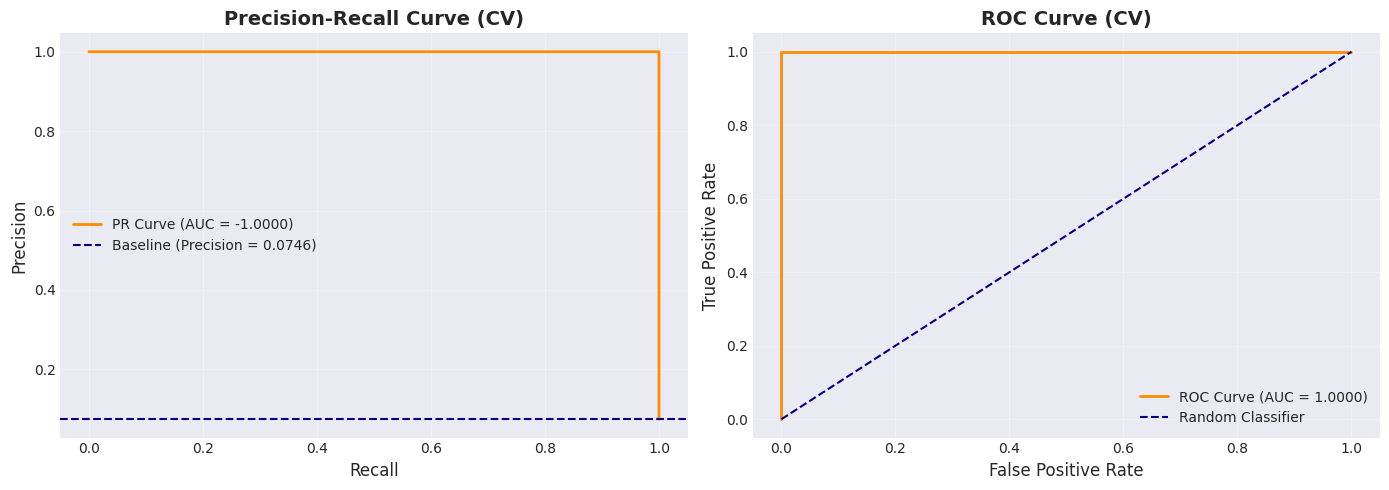

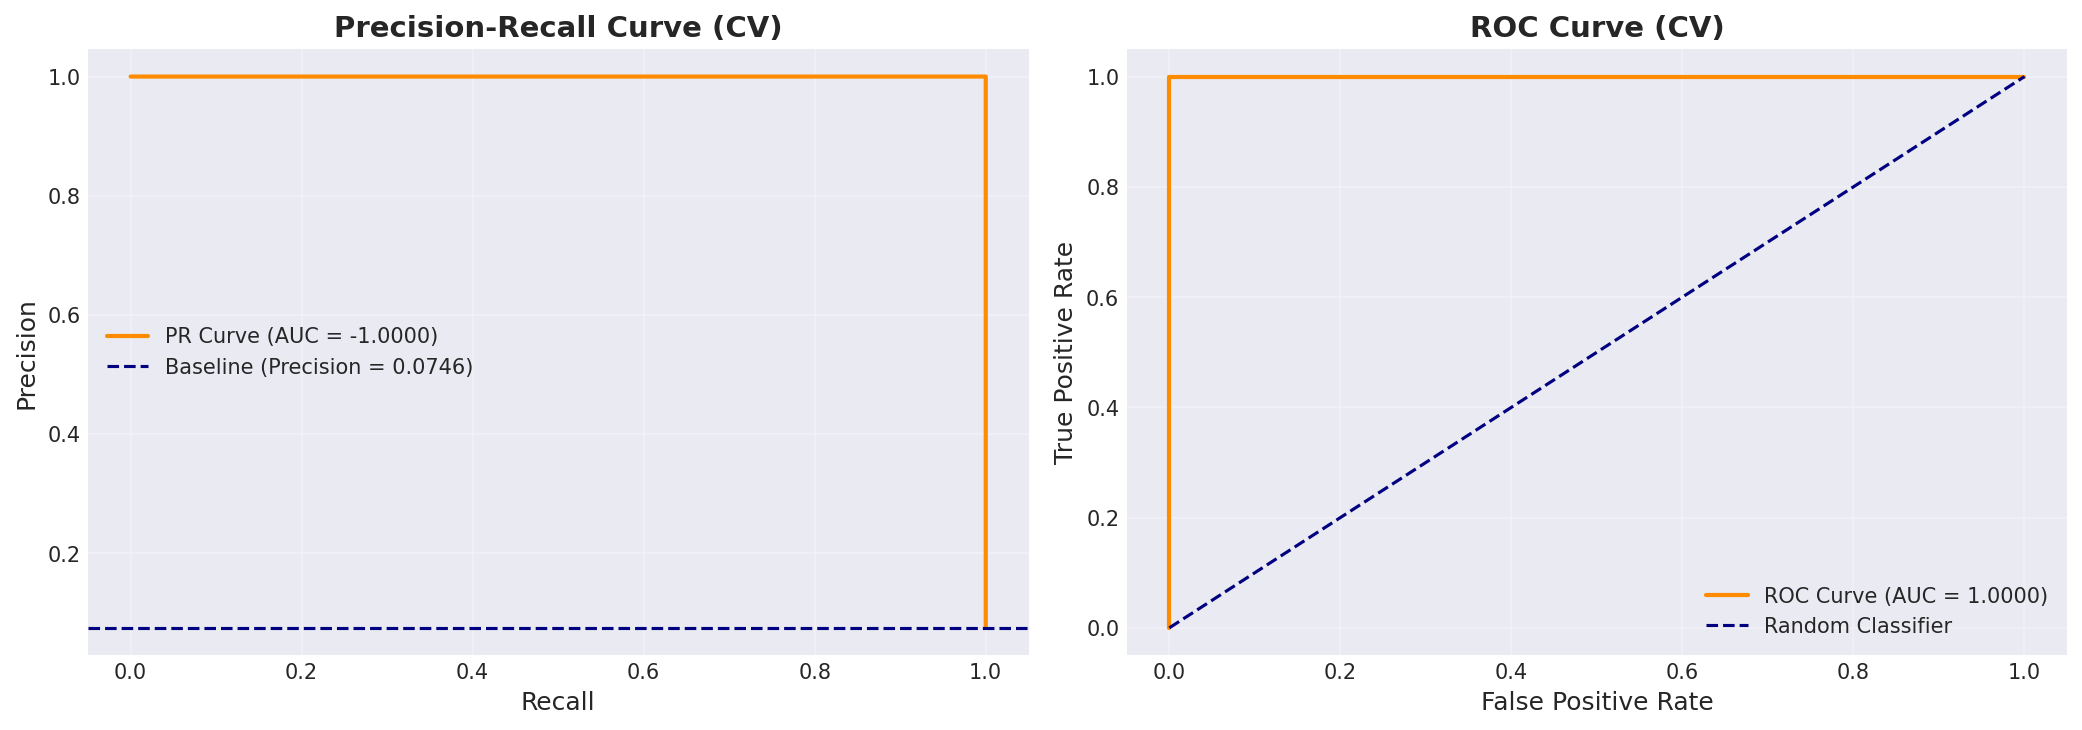

✅ CV curves saved to: logs/model_xgboost_cv_curves.png


In [15]:
# ============================================
# VISUALIZATION: CV Performance Curves
# ============================================
try:
    print("\n" + "=" * 80)
    print("PLOTTING: Cross-Validation Performance Curves")
    print("=" * 80)
    
    # Get predictions from best model on CV data for visualization
    if ('search' in locals() and hasattr(search, 'best_estimator_')) or best_model is not None:
        # Use the best pipeline to get predictions
        # Use the best pipeline from RandomizedSearchCV
        if 'search' in locals() and hasattr(search, 'best_estimator_'):
            best_pipeline = search.best_estimator_
        elif best_model is not None:
            # Fallback: create pipeline with best model
            from sklearn.pipeline import Pipeline
            best_pipeline = Pipeline([('scaler', StandardScaler().fit(X_full)), ('model', best_model)])
        else:
            raise ValueError("No best model available")
        y_cv_proba = best_pipeline.predict_proba(X_full)[:, 1]
        
        # Calculate PR and ROC curves
        precision, recall, pr_thresholds = precision_recall_curve(y_full, y_cv_proba)
        fpr, tpr, roc_thresholds = roc_curve(y_full, y_cv_proba)
        roc_auc = roc_auc_score(y_full, y_cv_proba)
        
        # Create figure with subplots
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # PR Curve
        axes[0].plot(recall, precision, color='darkorange', lw=2, 
                    label=f'PR Curve (AUC = {np.trapz(precision, recall):.4f})')
        axes[0].axhline(y=y_full.mean(), color='navy', linestyle='--', 
                        label=f'Baseline (Precision = {y_full.mean():.4f})')
        axes[0].set_xlabel('Recall', fontsize=12)
        axes[0].set_ylabel('Precision', fontsize=12)
        axes[0].set_title('Precision-Recall Curve (CV)', fontsize=14, fontweight='bold')
        axes[0].legend(loc='best')
        axes[0].grid(True, alpha=0.3)
        
        # ROC Curve
        axes[1].plot(fpr, tpr, color='darkorange', lw=2, 
                    label=f'ROC Curve (AUC = {roc_auc:.4f})')
        axes[1].plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Classifier')
        axes[1].set_xlabel('False Positive Rate', fontsize=12)
        axes[1].set_ylabel('True Positive Rate', fontsize=12)
        axes[1].set_title('ROC Curve (CV)', fontsize=14, fontweight='bold')
        axes[1].legend(loc='best')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        cv_plot_path = PROJECT_ROOT / 'logs' / 'model_xgboost_cv_curves.png'
        plt.savefig(cv_plot_path, dpi=150, bbox_inches='tight')
        plt.show()  # Display plot in notebook
        display(Image(str(cv_plot_path)))  # Display inline
        print("✅ CV curves saved to: logs/model_xgboost_cv_curves.png")
        plt.close()
        cleanup_memory()
    else:
        print("⚠️ Skipping CV visualization (best_model or data not available)")
        
except Exception as e:
    print(f"⚠️ Error plotting CV curves: {e}")
    cleanup_memory()



## 7. Threshold Tuning & Final Evaluation

In [16]:
# Train final model on full data
try:
    print("\n" + "=" * 80)
    print("PHASE 6: Final Model Training & Threshold Tuning")
    print("=" * 80)
    phase_start = time.time()
    print("Training Final Model on Full Dataset...")

    # Use best parameters, or defaults if best_params is None
    # Initialize best_params if not set
    if 'best_params' not in locals():
        best_params = {}
        best_cv_score = 0.0
        print("  ⚠️ best_params not found, using defaults")

    # Initialize best_params if not set
    try:
        _ = best_params
    except NameError:
        best_params = {}
        best_cv_score = 0.0
        print("  ⚠️ best_params not found, using defaults")

    # Use best parameters, or defaults if best_params is None
    # Initialize best_params if not set (from hyperparameter tuning)
    if 'best_params' not in globals():
        best_params = {}
        best_cv_score = 0.0
        print("  ⚠️ best_params not found, using defaults")

    # Use best parameters, or defaults if best_params is None
    final_params = best_params.copy() if best_params else {}

    # Set safe defaults to prevent warnings
    final_params['min_split_gain'] = 0.0
    final_params.setdefault('min_child_samples', 5)
    
    # Remove scale_pos_weight from final_params if present (we'll set it explicitly)
    final_params.pop('scale_pos_weight', None)
    
    # Calculate balanced scale_pos_weight for final model
    scale_pos_weight_final = (y_train == 0).sum() / max((y_train == 1).sum(), 1)

    # Use class_weight if SMOTE was skipped
    use_class_weight = globals().get('USE_CLASS_WEIGHT', False)
    if use_class_weight:
        scale_pos_weight_final = (y_train == 0).sum() / max((y_train == 1).sum(), 1)
        print(f"  Using class_weight (SMOTE skipped): scale_pos_weight={scale_pos_weight_final:.4f}")
    else:
        scale_pos_weight_final = final_params.pop('scale_pos_weight', None) or ((y_train == 0).sum() / max((y_train == 1).sum(), 1))
    
    final_model = XGBClassifier(
        tree_method="hist",
        eval_metric="logloss",
        verbosity=0,
        **final_params,
        random_state=SEED,
        n_jobs=2,
        objective='binary:logistic',
        verbose=-1,
        scale_pos_weight=scale_pos_weight_final,
        max_bin=256,
    )

    # Aggressive cleanup before final training
    cleanup_memory()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("  Memory cleaned before final training")

    # Train with early stopping
    print("  Training with early stopping...")
    try:
        # Try new XGBoost API (2.0+) with callbacks
        from xgboost import callback
        final_model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[callback.EarlyStopping(rounds=50, save_best=True)],
            verbose=False
        )
    except (TypeError, AttributeError):
        # Fallback to old API or no early stopping
        try:
            final_model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                early_stopping_rounds=50,
                verbose=False
            )
        except TypeError:
            # If both fail, train without early stopping
            print("  ⚠️ Early stopping not supported, training without it")
            final_model.fit(X_train, y_train)

    # Get predictions on validation set (original split)
    y_val_proba = safe_prediction(final_model.predict_proba, X=X_val)[:, 1]

    # Find optimal threshold using precision-recall curve
    precision, recall, pr_thresholds = precision_recall_curve(y_val, y_val_proba)
    f1_scores_pr = 2 * (precision * recall) / (precision + recall + 1e-10)
    best_pr_idx = np.argmax(f1_scores_pr)
    best_pr_threshold = pr_thresholds[best_pr_idx] if best_pr_idx < len(pr_thresholds) else 0.5
    best_pr_f1 = f1_scores_pr[best_pr_idx]

    # Manual fine-grained search in optimal region
    thresholds = np.concatenate([
        np.linspace(0.01, 0.05, 20),
        np.linspace(0.05, 0.15, 50),
        np.linspace(0.15, 0.3, 30),
        np.linspace(0.3, 0.9, 20)
    ])

    best_threshold = best_pr_threshold
    best_f1 = best_pr_f1
    for thr in thresholds:
        y_pred = (y_val_proba >= thr).astype(int)
        f1 = f1_score(y_val, y_pred, pos_label=1, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thr

    phase_time = time.time() - phase_start
    print(f"\n✅ Final Optimal Threshold: {best_threshold:.4f}")
    print(f"✅ Final Validation F1: {best_f1:.4f}")
    print(f"\n⏱️  Final Model Training & Threshold Tuning Time: {phase_time:.2f} seconds ({phase_time/60:.2f} minutes)")

    # Classification report
    y_val_pred = (y_val_proba >= best_threshold).astype(int)
    print("\n📊 Classification Report:")
    print(classification_report(y_val, y_val_pred, digits=4, zero_division=0))

    cleanup_memory()
    memory_usage()

except Exception as e:
    print(f"❌ Error in final training: {e}")
    raise


PHASE 6: Final Model Training & Threshold Tuning
Training Final Model on Full Dataset...


  Memory cleaned before final training


  Training with early stopping...
  ⚠️ Early stopping not supported, training without it



✅ Final Optimal Threshold: 0.7623
✅ Final Validation F1: 0.5125

⏱️  Final Model Training & Threshold Tuning Time: 1913.33 seconds (31.89 minutes)

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9716    0.9427    0.9569    111925
           1     0.4376    0.6183    0.5125      8075

    accuracy                         0.9208    120000
   macro avg     0.7046    0.7805    0.7347    120000
weighted avg     0.9357    0.9208    0.9270    120000



💾 Memory: 43.82 GB (RAM) | 0.00/0.00 GB (GPU used/reserved)



PLOTTING: Final Model Performance Visualizations


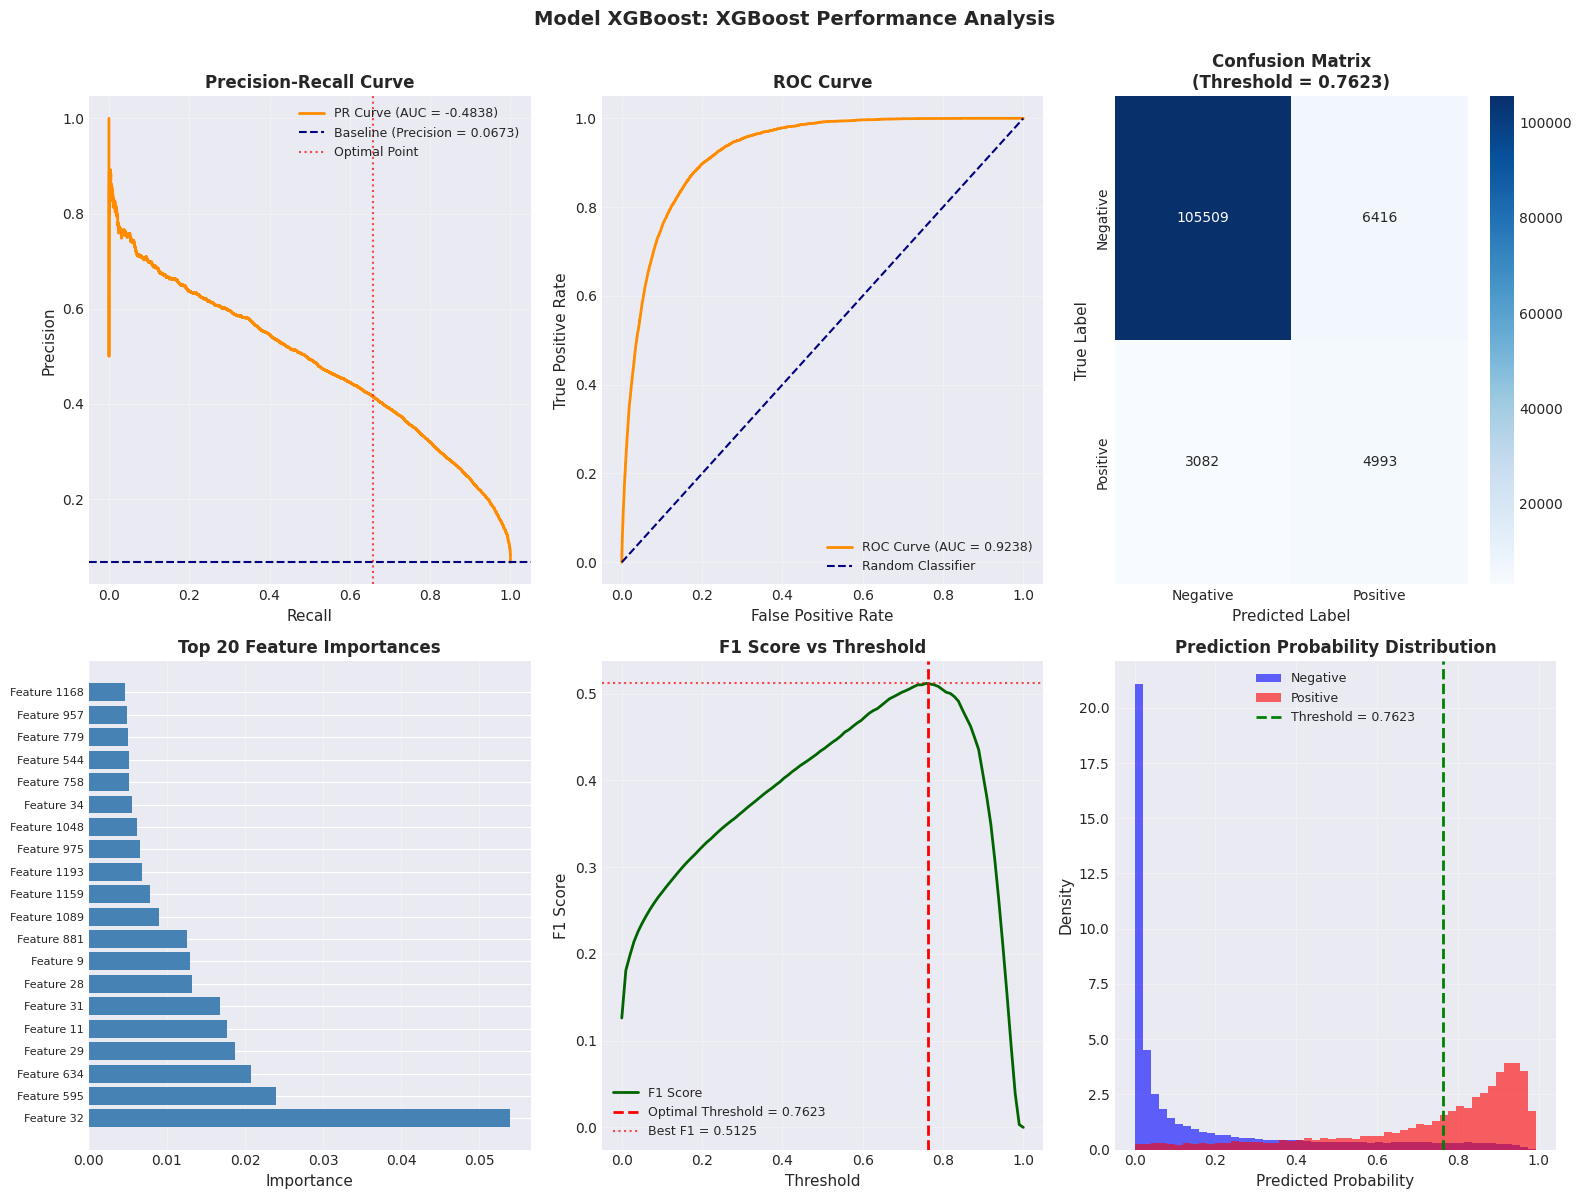

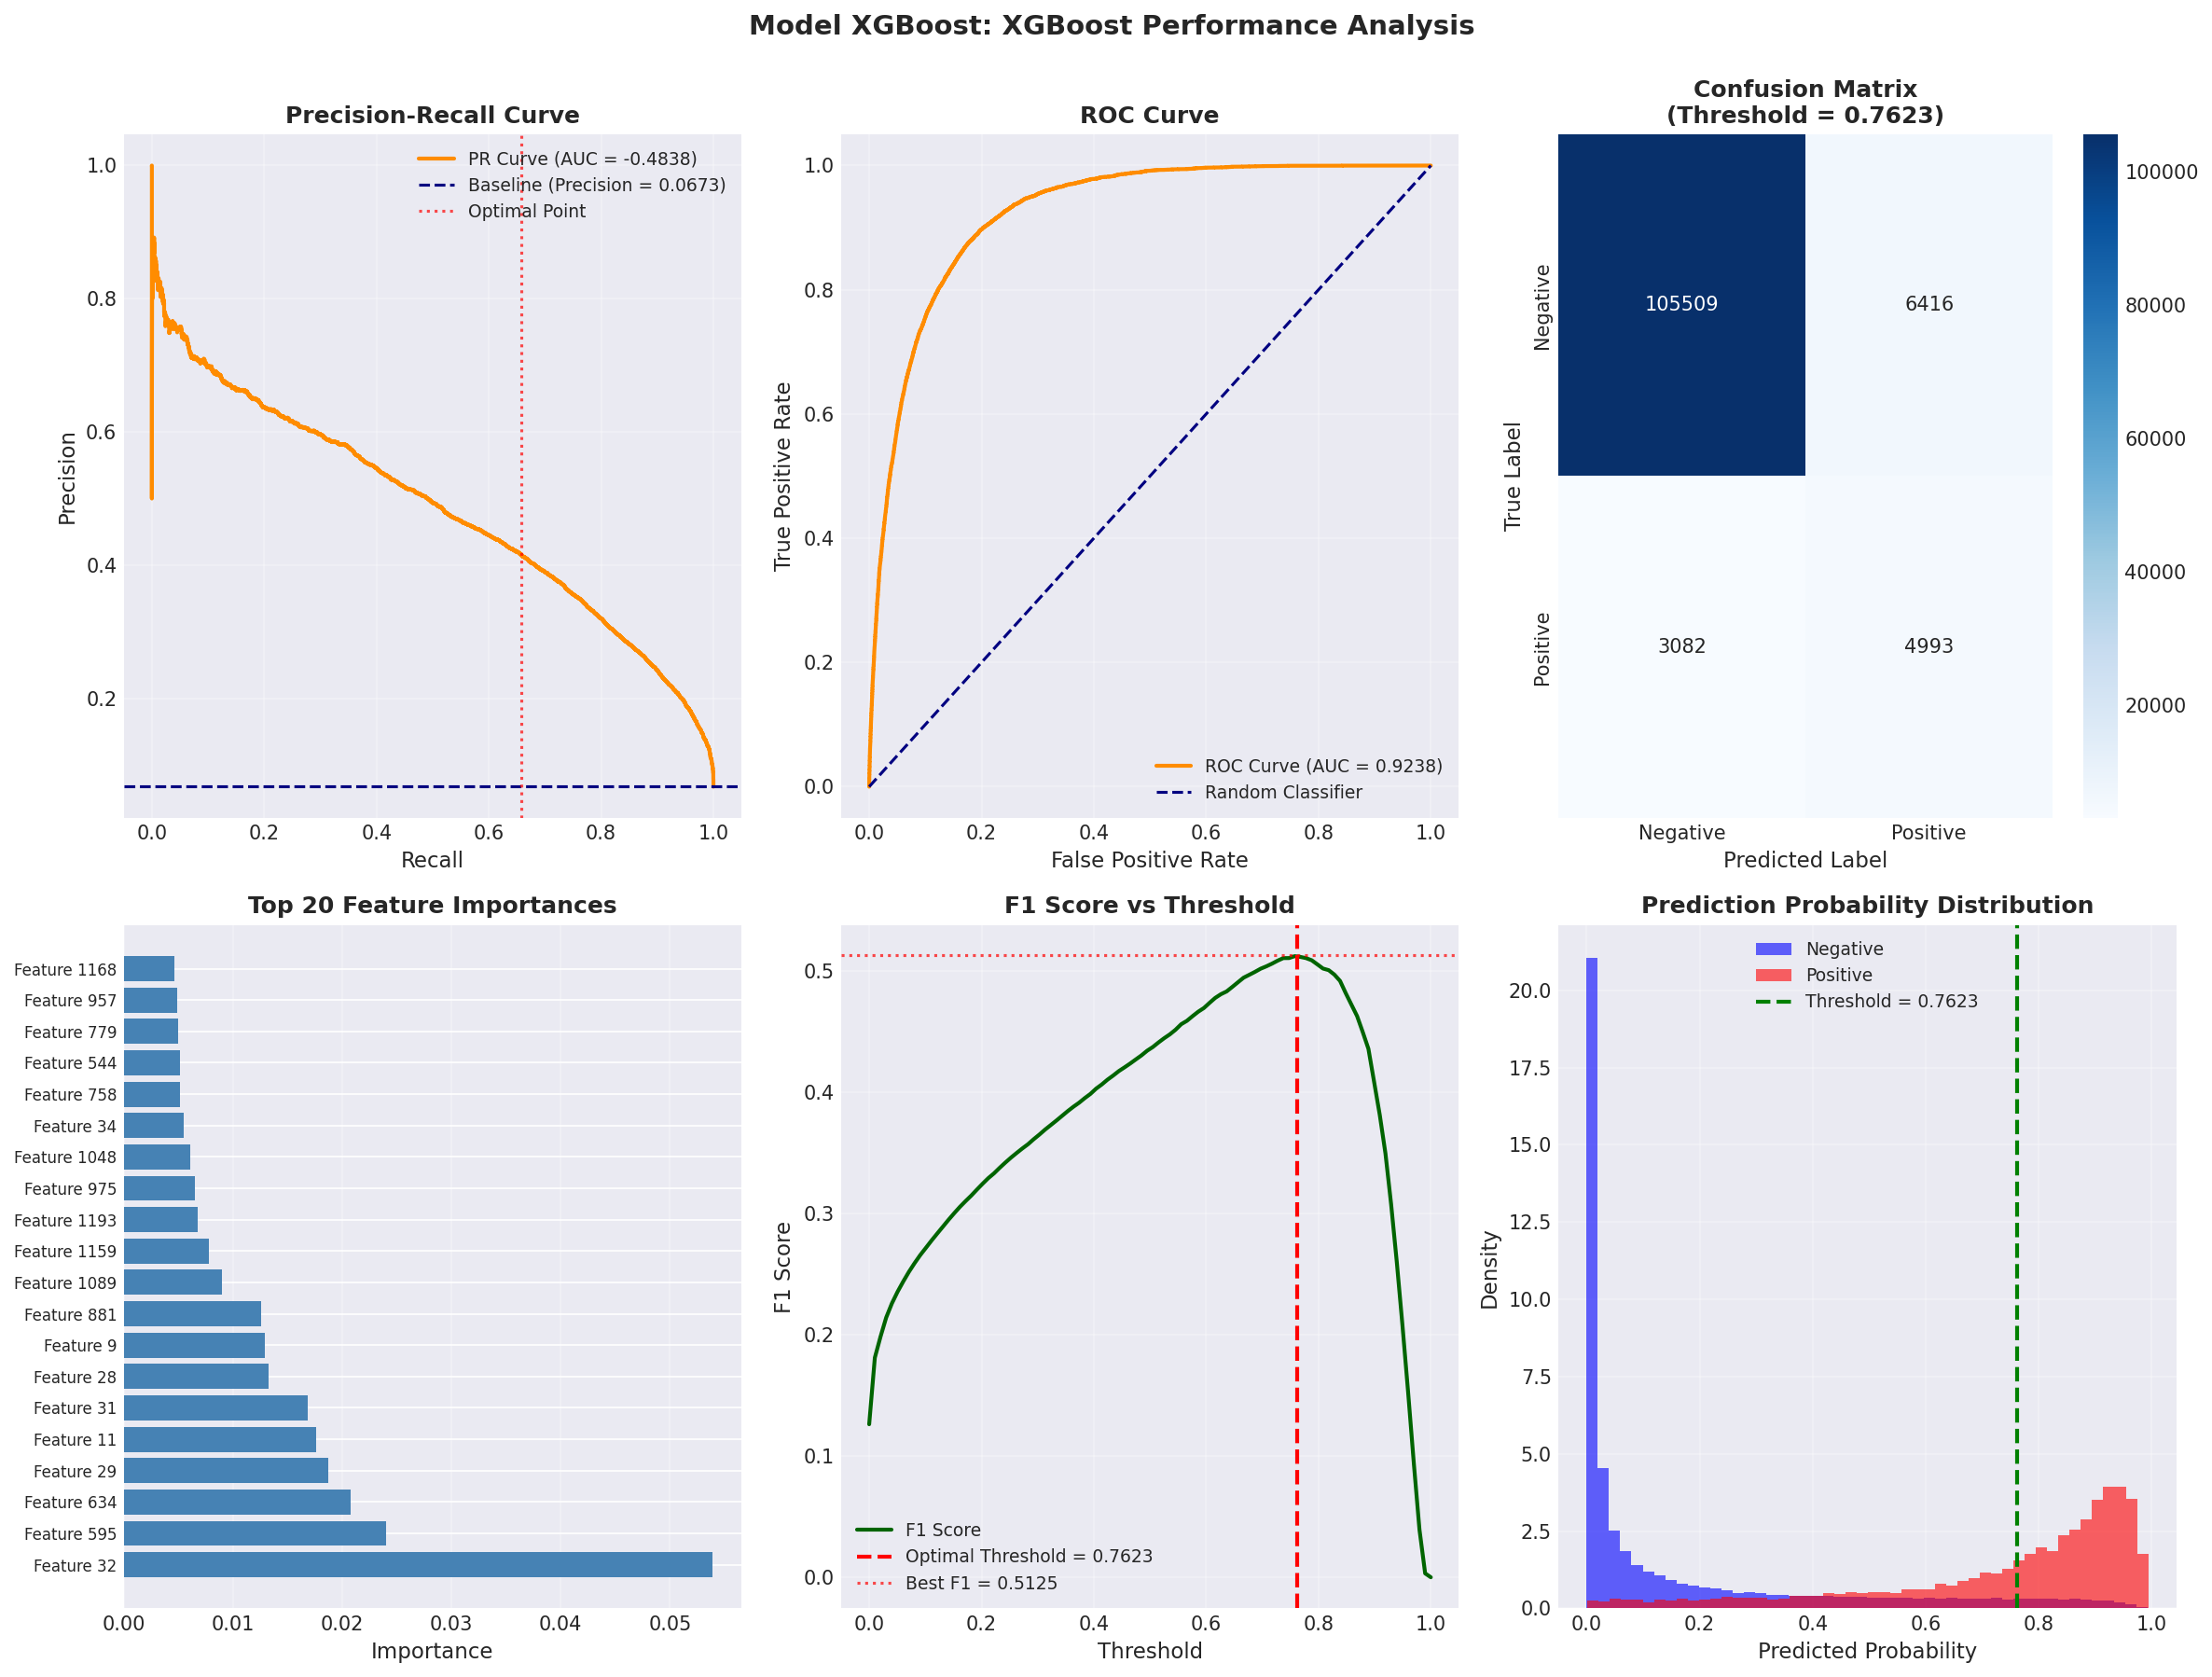

✅ Final performance plots saved to: logs/model_xgboost_final_performance.png


In [17]:
# ============================================
# VISUALIZATION: Final Model Performance
# ============================================
try:
    print("\n" + "=" * 80)
    print("PLOTTING: Final Model Performance Visualizations")
    print("=" * 80)
    
    if 'final_model' in locals() and 'y_val_proba' in locals() and 'y_val' in locals():
        # Calculate curves
        precision, recall, pr_thresholds = precision_recall_curve(y_val, y_val_proba)
        fpr, tpr, roc_thresholds = roc_curve(y_val, y_val_proba)
        roc_auc = roc_auc_score(y_val, y_val_proba)
        pr_auc = np.trapz(precision, recall)
        
        # Create comprehensive figure
        fig = plt.figure(figsize=(16, 12))
        
        # 1. PR Curve
        ax1 = plt.subplot(2, 3, 1)
        ax1.plot(recall, precision, color='darkorange', lw=2, 
                label=f'PR Curve (AUC = {pr_auc:.4f})')
        ax1.axhline(y=y_val.mean(), color='navy', linestyle='--', 
                   label=f'Baseline (Precision = {y_val.mean():.4f})')
        ax1.axvline(x=recall[np.argmax(precision * recall)], color='red', linestyle=':', 
                   alpha=0.7, label=f'Optimal Point')
        ax1.set_xlabel('Recall', fontsize=11)
        ax1.set_ylabel('Precision', fontsize=11)
        ax1.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
        ax1.legend(loc='best', fontsize=9)
        ax1.grid(True, alpha=0.3)
        
        # 2. ROC Curve
        ax2 = plt.subplot(2, 3, 2)
        ax2.plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC Curve (AUC = {roc_auc:.4f})')
        ax2.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Classifier')
        ax2.set_xlabel('False Positive Rate', fontsize=11)
        ax2.set_ylabel('True Positive Rate', fontsize=11)
        ax2.set_title('ROC Curve', fontsize=12, fontweight='bold')
        ax2.legend(loc='best', fontsize=9)
        ax2.grid(True, alpha=0.3)
        
        # 3. Confusion Matrix
        ax3 = plt.subplot(2, 3, 3)
        cm = confusion_matrix(y_val, y_val_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3, 
                   xticklabels=['Negative', 'Positive'], 
                   yticklabels=['Negative', 'Positive'])
        ax3.set_ylabel('True Label', fontsize=11)
        ax3.set_xlabel('Predicted Label', fontsize=11)
        ax3.set_title(f'Confusion Matrix\n(Threshold = {best_threshold:.4f})', 
                     fontsize=12, fontweight='bold')
        
        # 4. Feature Importance (Top 20)
        ax4 = plt.subplot(2, 3, 4)
        if hasattr(final_model, 'feature_importances_'):
            feature_importance = final_model.feature_importances_
            top_n = min(20, len(feature_importance))
            top_indices = np.argsort(feature_importance)[-top_n:][::-1]
            top_importance = feature_importance[top_indices]
            ax4.barh(range(top_n), top_importance, color='steelblue')
            ax4.set_yticks(range(top_n))
            ax4.set_yticklabels([f'Feature {i}' for i in top_indices], fontsize=8)
            ax4.set_xlabel('Importance', fontsize=11)
            ax4.set_title(f'Top {top_n} Feature Importances', fontsize=12, fontweight='bold')
            ax4.grid(True, alpha=0.3, axis='x')
        else:
            ax4.text(0.5, 0.5, 'Feature importance\nnot available', 
                    ha='center', va='center', transform=ax4.transAxes, fontsize=12)
            ax4.set_title('Feature Importance', fontsize=12, fontweight='bold')
        
        # 5. Threshold Analysis
        ax5 = plt.subplot(2, 3, 5)
        thresholds_fine = np.linspace(0, 1, 100)
        f1_scores_fine = []
        for thr in thresholds_fine:
            y_pred_thr = (y_val_proba >= thr).astype(int)
            f1_thr = f1_score(y_val, y_pred_thr, pos_label=1, zero_division=0)
            f1_scores_fine.append(f1_thr)
        ax5.plot(thresholds_fine, f1_scores_fine, color='darkgreen', lw=2, label='F1 Score')
        ax5.axvline(x=best_threshold, color='red', linestyle='--', lw=2, 
                   label=f'Optimal Threshold = {best_threshold:.4f}')
        ax5.axhline(y=best_f1, color='red', linestyle=':', alpha=0.7, 
                   label=f'Best F1 = {best_f1:.4f}')
        ax5.set_xlabel('Threshold', fontsize=11)
        ax5.set_ylabel('F1 Score', fontsize=11)
        ax5.set_title('F1 Score vs Threshold', fontsize=12, fontweight='bold')
        ax5.legend(loc='best', fontsize=9)
        ax5.grid(True, alpha=0.3)
        
        # 6. Prediction Distribution
        ax6 = plt.subplot(2, 3, 6)
        ax6.hist(y_val_proba[y_val == 0], bins=50, alpha=0.6, label='Negative', 
                color='blue', density=True)
        ax6.hist(y_val_proba[y_val == 1], bins=50, alpha=0.6, label='Positive', 
                color='red', density=True)
        ax6.axvline(x=best_threshold, color='green', linestyle='--', lw=2, 
                   label=f'Threshold = {best_threshold:.4f}')
        ax6.set_xlabel('Predicted Probability', fontsize=11)
        ax6.set_ylabel('Density', fontsize=11)
        ax6.set_title('Prediction Probability Distribution', fontsize=12, fontweight='bold')
        ax6.legend(loc='best', fontsize=9)
        ax6.grid(True, alpha=0.3)
        
        plt.suptitle('Model XGBoost: XGBoost Performance Analysis', fontsize=14, fontweight='bold', y=0.995)
        plt.tight_layout()
        final_plot_path = PROJECT_ROOT / 'logs' / 'model_xgboost_final_performance.png'
        plt.savefig(final_plot_path, dpi=150, bbox_inches='tight')
        plt.show()  # Display plot in notebook
        display(Image(str(final_plot_path)))  # Display inline
        print("✅ Final performance plots saved to: logs/model_xgboost_final_performance.png")
        plt.close()
        cleanup_memory()
    else:
        print("⚠️ Skipping final visualization (final_model or predictions not available)")
        
except Exception as e:
    print(f"⚠️ Error plotting final performance: {e}")
    import traceback
    traceback.print_exc()
    cleanup_memory()



## 8. Save Model

In [18]:
# Save model with calibration
try:
    from sklearn.calibration import CalibratedClassifierCV
    
    model_save_path = MODEL_SAVE_DIR / "model_xgboost_all_features_best.pkl"

    # Calibrate model probabilities before saving
    print("\n📊 Calibrating model probabilities...")
    calibrated_model = CalibratedClassifierCV(
        final_model,
        method='isotonic',
        cv=3,
        n_jobs=1  # Sequential processing for memory efficiency
    )
    calibrated_model.fit(X_train, y_train)
    print("  ✅ Model calibrated")
    
    # Use calibrated model for predictions
    y_val_proba_calibrated = calibrated_model.predict_proba(X_val)[:, 1]
    
    # Re-optimize threshold on calibrated predictions
    precision_cal, recall_cal, pr_thresholds_cal = precision_recall_curve(y_val, y_val_proba_calibrated)
    f1_scores_cal = 2 * (precision_cal * recall_cal) / (precision_cal + recall_cal + 1e-10)
    best_cal_idx = np.argmax(f1_scores_cal)
    best_threshold_cal = pr_thresholds_cal[best_cal_idx] if best_cal_idx < len(pr_thresholds_cal) else 0.5
    best_f1_cal = f1_scores_cal[best_cal_idx]
    
    print(f"  Calibrated F1: {best_f1_cal:.4f} (vs original {best_f1:.4f})")
    print(f"  Calibrated threshold: {best_threshold_cal:.4f}")

    save_dict = {
        "model": calibrated_model,  # Save calibrated model
        "scaler": scaler if 'scaler' in locals() else None,
        "pca_models": pca_models if 'pca_models' in locals() else None,
        "best_params": best_params,
        "best_cv_score": best_cv_score,
        "best_threshold": best_threshold_cal,  # Use calibrated threshold
        "best_f1": best_f1_cal,  # Use calibrated F1
        "reg_cols": reg_cols,
        "emb_family_to_cols": emb_family_to_cols,
    }

    with open(model_save_path, "wb") as f:
        pickle.dump(save_dict, f)

    print(f"\n💾 Model saved to: {model_save_path}")

except Exception as e:
    print(f"❌ Error saving model: {e}")
    import traceback
    traceback.print_exc()



📊 Calibrating model probabilities...


  ✅ Model calibrated


  Calibrated F1: 0.5138 (vs original 0.5125)
  Calibrated threshold: 0.2535

💾 Model saved to: /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/models/saved_models/model_xgboost_all_features_best.pkl


## 9. Generate Submission

In [19]:
import re

def extract_work_id(id_value: str) -> str:
    """Extract work_id from URL or return as is if already just ID."""
    id_str = str(id_value)
    # If it already looks like a work ID, just return it
    if id_str.startswith('W') and len(id_str) > 1 and '/' not in id_str:
        return id_str
    # Otherwise, extract from URL or string
    match = re.search(r'W\d+', id_str)
    if match:
        return match.group(0)
    return id_str

# Load test data and generate predictions
try:
    print("\n" + "=" * 80)
    print("PHASE 7: Test Predictions")
    print("=" * 80)
    phase_start = time.time()
    print("Generating Test Predictions...")

    test_df = load_parquet_split("test")
    test_ids = test_df["id"].to_numpy()

    # Process test data same as train
    X_reg_test, X_emb_test_fams, _, _, _ = split_features_reg_and_all_emb(test_df)
    del test_df

    # Apply PCA (if enabled) or use embeddings directly
    if USE_PCA and 'pca_models' in locals() and pca_models:
        # Apply PCA using trained models
        X_emb_test_pca, _ = apply_pca_to_embeddings(
            X_emb_test_fams, fit_on_train=False, pca_models=pca_models
        )
        
        # Combine features
        if X_reg_test is not None:
            X_test = np.hstack([X_reg_test, X_emb_test_pca])
        else:
            X_test = X_emb_test_pca
        
        del X_emb_test_pca
    else:
        # No PCA - combine embeddings directly
        X_emb_test_list = [X_emb_test_fams[fam] for fam in X_emb_test_fams.keys()]
        X_emb_test_combined = np.hstack(X_emb_test_list) if X_emb_test_list else None
        
        # Combine features
        if X_reg_test is not None:
            X_test = np.hstack([X_reg_test, X_emb_test_combined])
        else:
            X_test = X_emb_test_combined
        
        del X_emb_test_list, X_emb_test_combined

    del X_reg_test, X_emb_test_fams
    cleanup_memory()

    # Scale
    if "scaler" in locals():
        X_test = scaler.transform(X_test)

    # Predict in chunks for Out Of Memory protection
    chunk_size = 10000
    if X_test.shape[0] > chunk_size:
        print(f"  Predicting in chunks (size={chunk_size}) for OOM protection...")
        y_test_proba_chunks = []
        for i in range(0, X_test.shape[0], chunk_size):
            chunk_proba = safe_prediction(final_model.predict_proba, X=X_test[i : i + chunk_size])[:, 1]
            y_test_proba_chunks.append(chunk_proba)
            del chunk_proba
            cleanup_memory()
        y_test_proba = np.concatenate(y_test_proba_chunks)
        del y_test_proba_chunks
    else:
        y_test_proba = safe_prediction(final_model.predict_proba, X=X_test)[:, 1]

    y_test_pred = (y_test_proba >= best_threshold).astype(int)

    # Create submission using Polars
    work_ids = np.array([extract_work_id(str(id_val)) for id_val in test_ids])
    submission_df = pl.DataFrame({"work_id": work_ids, "label": y_test_pred})

    submission_path = SUBMISSION_DIR / "submission_model_xgboost.csv"
    submission_df.write_csv(submission_path)

    phase_time = time.time() - phase_start
    print(f"\n✅ Submission saved to: {submission_path}")
    print(f"  Test predictions: {len(y_test_pred)}, Positive: {y_test_pred.sum()}, Negative: {(y_test_pred==0).sum()}")
    print(f"\n⏱️  Test Predictions Time: {phase_time:.2f} seconds ({phase_time/60:.2f} minutes)")

    cleanup_memory()
    memory_usage()
    
    # Print total execution time summary
    total_time = time.time() - TOTAL_START_TIME
    print(f"\n{'='*80}")
    # Print total execution time summary
    total_time = time.time() - TOTAL_START_TIME
    END_TIME_STR = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print(f"\n{'='*80}")
    print(f"MODEL_XGBOOST EXECUTION COMPLETED")
    print(f"Start Time: {START_TIME_STR}")
    print(f"End Time: {END_TIME_STR}")
    print(f"Total Execution Time: {total_time:.2f} seconds ({total_time/60:.2f} minutes / {total_time/3600:.2f} hours)")
    print(f"Final Validation F1 Score: {best_f1:.4f}")
    print(f"{'='*80}\n")
    print(f"End Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Final Validation F1 Score: {best_f1:.4f}")
    print(f"{'='*80}\n")

except Exception as e:
    total_time = time.time() - TOTAL_START_TIME
    print(f"\n❌ Error generating submission: {e}")
    print(f"Execution failed after {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
    raise



PHASE 7: Test Predictions
Generating Test Predictions...
Loading test from /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/data/model_ready/test_model_ready.parquet


  Predicting in chunks (size=10000) for OOM protection...



✅ Submission saved to: /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/data/submission_files/submission_model_xgboost.csv
  Test predictions: 120000, Positive: 11271, Negative: 108729

⏱️  Test Predictions Time: 17.45 seconds (0.29 minutes)


💾 Memory: 48.89 GB (RAM) | 0.00/0.00 GB (GPU used/reserved)


MODEL_XGBOOST EXECUTION COMPLETED
Start Time: 2025-11-20 00:40:53
End Time: 2025-11-20 03:56:53
Total Execution Time: 11760.09 seconds (196.00 minutes / 3.27 hours)
Final Validation F1 Score: 0.5125

End Time: 2025-11-20 03:56:53
Final Validation F1 Score: 0.5125

